In [17]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.qchem import read_structure, molecule
from matplotlib import pyplot as plt
from pennylane import commutator

In [18]:
import numpy as np

symbols = ["H", "H"]
coordinates = np.array([
    [0.0, 0.0, 0.0],
    [0.0, 0.0, 0.74]  # unit Å
])



In [19]:
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, active_electrons=2, active_orbitals=2)
print(" qubits number:", qubits)
# 3. define quantum device
dev = qml.device("default.qubit", wires=qubits)

 qubits number: 4


In [20]:
from pennylane import qchem

H_c, qubits = qchem.molecular_hamiltonian(
    symbols,
    coordinates,
    method='pyscf',
    basis='sto-3g'
)
print(H_c)

0.7784107703315544 * I([0, 2, 1, 3]) + 0.23718739979583803 * Z(0) + -0.4612495808843312 * Z(2) + 0.1406570062079997 * (Z(0) @ Z(2)) + 0.23718739979583803 * Z(1) + 0.18456105273155665 * (Z(0) @ Z(1)) + 0.04104417944033013 * (Y(0) @ X(1) @ X(2) @ Y(3)) + -0.04104417944033013 * (Y(0) @ Y(1) @ X(2) @ X(3)) + -0.04104417944033013 * (X(0) @ X(1) @ Y(2) @ Y(3)) + 0.04104417944033013 * (X(0) @ Y(1) @ Y(2) @ X(3)) + -0.4612495808843312 * Z(3) + 0.18170118564832982 * (Z(0) @ Z(3)) + 0.1406570062079997 * (Z(1) @ Z(3)) + 0.18170118564832982 * (Z(1) @ Z(2)) + 0.1917875067959805 * (Z(2) @ Z(3))


In [21]:
def build_driver_h(n):
    coeffs = [-1.0] * n
    ops = [qml.PauliX(i) for i in range(n)]
    return qml.Hamiltonian(coeffs, ops)

driver_h = build_driver_h(qubits)
print(driver_h)


-1.0 * X(0) + -1.0 * X(1) + -1.0 * X(2) + -1.0 * X(3)


In [22]:
def build_commutator_hamiltonian(H_d, H_c):
    comm_terms = []

    coeffs_d, ops_d = H_d.terms()
    coeffs_c, ops_c = H_c.terms()

    for c1, op1 in zip(coeffs_d, ops_d):
        for c2, op2 in zip(coeffs_c, ops_c):
            try:
                comm = commutator(op1, op2)
                # check no commute term
                if isinstance(comm, qml.ops.op_math.Sum) and len(comm.operands) == 0:
                    continue  
                
                # multiply j
                comm_terms.append(1j * c1 * c2 * comm)

            except Exception as e:
                print(f"跳过某个项：[{op1}, {op2}] 计算 commutator 出错，原因：{e}")
                continue

    if len(comm_terms) == 0:
        print("所有 commutators 都是 0")
        return qml.Hamiltonian([], [])
    
    # 合并所有项
    full_comm = sum(comm_terms)
    return full_comm.simplify()

comm_h=build_commutator_hamiltonian(driver_h,H_c)
print(comm_h)

(-0.47437479959167606+0j) * Y(0) + (-0.2813140124159994+0j) * (Y(0) @ Z(2)) + (-0.3691221054631133+0j) * (Y(0) @ Z(1)) + (0.08208835888066025+0j) * (Z(0) @ X(1) @ X(2) @ Y(3)) + (-0.08208835888066025+0j) * (Z(0) @ Y(1) @ X(2) @ X(3)) + (-0.36340237129665964+0j) * (Y(0) @ Z(3)) + (-0.47437479959167606+0j) * Y(1) + (-0.3691221054631133+0j) * (Z(0) @ Y(1)) + (-0.08208835888066025+0j) * (Y(0) @ Z(1) @ X(2) @ X(3)) + (0.08208835888066025+0j) * (X(0) @ Z(1) @ Y(2) @ X(3)) + (-0.2813140124159994+0j) * (Y(1) @ Z(3)) + (-0.36340237129665964+0j) * (Y(1) @ Z(2)) + (0.9224991617686624+0j) * Y(2) + (-0.2813140124159994+0j) * (Z(0) @ Y(2)) + (-0.08208835888066025+0j) * (X(0) @ X(1) @ Z(2) @ Y(3)) + (0.08208835888066025+0j) * (X(0) @ Y(1) @ Z(2) @ X(3)) + (-0.36340237129665964+0j) * (Z(1) @ Y(2)) + (-0.383575013591961+0j) * (Y(2) @ Z(3)) + (0.08208835888066025+0j) * (Y(0) @ X(1) @ X(2) @ Z(3)) + (-0.08208835888066025+0j) * (X(0) @ X(1) @ Y(2) @ Z(3)) + (0.9224991617686624+0j) * Y(3) + (-0.36340237129

In [23]:
'''
from pennylane import commutator
from pennylane import commutator, Hamiltonian

def build_commutator_hamiltonian(H_d, H_c):
    comm_terms = []

    coeffs_d, ops_d = H_d.terms()
    coeffs_c, ops_c = H_c.terms()

    for c1, op1 in zip(coeffs_d, ops_d):
        for c2, op2 in zip(coeffs_c, ops_c):
            try:
                comm = commutator(op1, op2)
                # 检查 comm 是不是空的 Sum（即“无对易项”）
                if isinstance(comm, qml.ops.op_math.Sum) and len(comm.operands) == 0:
                    continue  # 是空项就跳过
                
                comm_terms.append(c1 * c2 * comm)
            except Exception as e:
                print(f"跳过某个项：[{op1}, {op2}] 计算 commutator 出错，原因：{e}")
                continue

    if len(comm_terms) == 0:
        print("所有 commutators 都是 0")
        return Hamiltonian([], [])
    
    # 合并所有项
    full_comm = sum(comm_terms)
    return full_comm.simplify()

comm_h=build_commutator_hamiltonian(driver_h,H_c)
print(comm_h)
'''

'\nfrom pennylane import commutator\nfrom pennylane import commutator, Hamiltonian\n\ndef build_commutator_hamiltonian(H_d, H_c):\n    comm_terms = []\n\n    coeffs_d, ops_d = H_d.terms()\n    coeffs_c, ops_c = H_c.terms()\n\n    for c1, op1 in zip(coeffs_d, ops_d):\n        for c2, op2 in zip(coeffs_c, ops_c):\n            try:\n                comm = commutator(op1, op2)\n                # 检查 comm 是不是空的 Sum（即“无对易项”）\n                if isinstance(comm, qml.ops.op_math.Sum) and len(comm.operands) == 0:\n                    continue  # 是空项就跳过\n                \n                comm_terms.append(c1 * c2 * comm)\n            except Exception as e:\n                print(f"跳过某个项：[{op1}, {op2}] 计算 commutator 出错，原因：{e}")\n                continue\n\n    if len(comm_terms) == 0:\n        print("所有 commutators 都是 0")\n        return Hamiltonian([], [])\n    \n    # 合并所有项\n    full_comm = sum(comm_terms)\n    return full_comm.simplify()\n\ncomm_h=build_commutator_hamiltonian(driver_h,H_c)\npri

In [24]:
# 6. build FALQON layer
def falqon_layer(beta_k, cost_h, driver_h, delta_t):
    qml.ApproxTimeEvolution(cost_h, delta_t, 1)
    qml.ApproxTimeEvolution(driver_h, beta_k * delta_t, 1)


In [25]:
# 7. build ansatz（多层 feedback 演化）
def build_ansatz(cost_h, driver_h, delta_t):
    def ansatz(beta, **kwargs):
        for w in dev.wires:
            qml.Hadamard(wires=w)  # 初始化为 |+⟩

        if len(beta) > 1:
            
            qml.layer(falqon_layer, len(beta) - 1, beta[:-1],
                      cost_h=cost_h, driver_h=driver_h, delta_t=delta_t)
        
        
        falqon_layer(beta[-1], cost_h, driver_h, delta_t)
        
    return ansatz

In [26]:
# 8. 构建测量电路（测量 cost_h 或 comm_h 的期望值）
def expval_circuit(beta, measurement_h):
    ansatz = build_ansatz(H, driver_h, delta_t)
    ansatz(beta)
    return qml.expval(measurement_h)

In [27]:
# 9. 主过程：运行 FBQA，生成 β 序列与能量估计
def run_fbqa(H, driver_h, comm_h, n_steps, beta_1, delta_t):
    beta_list = [beta_1]
    energy_list = []

    cost_fn = qml.QNode(expval_circuit, dev, interface="autograd")

    for i in range(n_steps):
        # 用 commutator 哈密顿量测量当前态，得到下一层 feedback 参数
        next_beta = -delta_t * cost_fn(beta_list, measurement_h=comm_h)
        beta_list.append(next_beta)

        # 计算当前 ansatz 态的能量期望
        energy = cost_fn(beta_list, measurement_h=H)
        energy_list.append(energy)
        print(f"第 {i+1} 步: E = {energy:.8f} Ha, β_{i+1} = {next_beta:.6f}")

    return beta_list, energy_list

In [29]:
# 10. 参数设定并运行
n_steps = 50
delta_t = 0.1
beta_1 = 0.0

res_beta, res_energies = run_fbqa(H, driver_h, comm_h, n_steps, beta_1, delta_t)

第 1 步: E = 0.77634946 Ha, β_1 = 0.036137-0.000000j
第 2 步: E = 0.76901962 Ha, β_2 = 0.071539-0.000000j
第 3 步: E = 0.75472712 Ha, β_3 = 0.105414-0.000000j
第 4 步: E = 0.73213697 Ha, β_4 = 0.136929-0.000000j
第 5 步: E = 0.70069815 Ha, β_5 = 0.165248-0.000000j
第 6 步: E = 0.66071395 Ha, β_6 = 0.189598-0.000000j
第 7 步: E = 0.61330045 Ha, β_7 = 0.209341-0.000000j
第 8 步: E = 0.56022755 Ha, β_8 = 0.224058-0.000000j
第 9 步: E = 0.50366833 Ha, β_9 = 0.233598-0.000000j
第 10 步: E = 0.44590861 Ha, β_10 = 0.238099-0.000000j
第 11 步: E = 0.38907865 Ha, β_11 = 0.237963-0.000000j
第 12 步: E = 0.33495651 Ha, β_12 = 0.233787-0.000000j
第 13 步: E = 0.28486568 Ha, β_13 = 0.226279-0.000000j
第 14 步: E = 0.23966117 Ha, β_14 = 0.216173-0.000000j
第 15 步: E = 0.19977872 Ha, β_15 = 0.204153-0.000000j
第 16 步: E = 0.16531665 Ha, β_16 = 0.190812-0.000000j
第 17 步: E = 0.13612444 Ha, β_17 = 0.176634-0.000000j
第 18 步: E = 0.11188164 Ha, β_18 = 0.161996-0.000000j
第 19 步: E = 0.09216030 Ha, β_19 = 0.147184-0.000000j
第 20 步: E =

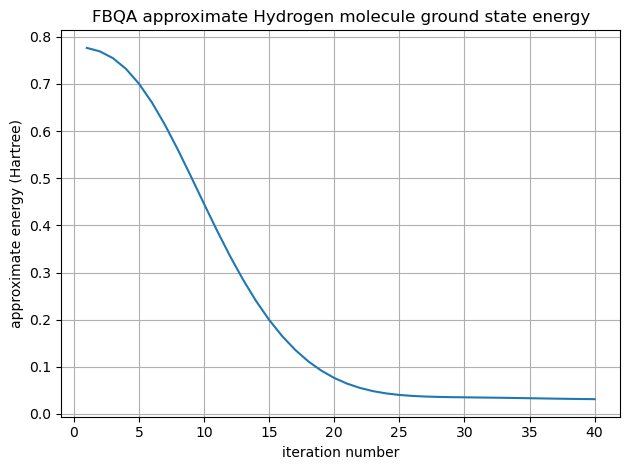

In [ ]:
plt.plot(range(1, n_steps + 1), res_energies)
plt.xlabel("iteration number")
plt.ylabel("approximate energy (Hartree)")
plt.title("FBQA approximate Hydrogen molecule ground state energy")
plt.grid(True)
plt.tight_layout()
plt.show()